In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
FIG_WIDTH = 12
FIGSIZE=(FIG_WIDTH, .618 * FIG_WIDTH)

# loading images

In [3]:
video = np.load('../montypython.npy')
N_X, N_Y, N_frame = video.shape
print('video.shape=', video.shape)

video.shape= (54, 54, 4096)


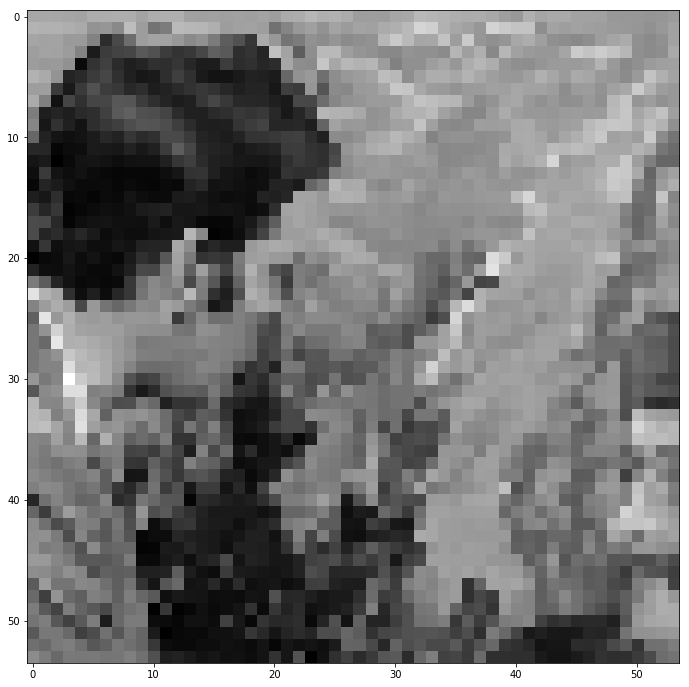

In [4]:
image = video[:, :, 2000]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(np.rot90(image), cmap=plt.gray())

# AR(1) filtering

In [5]:
alpha = -.61803

In [6]:
%%time
video_ar = np.zeros_like(video)
for i in range(N_frame):
    video_ar[:, :, i] = video[:, :, i] + alpha *video[:, :, i-1]
    

CPU times: user 2.99 s, sys: 238 ms, total: 3.23 s
Wall time: 3.26 s


In [7]:
%%time
video_ar = video + alpha * np.roll(video, 1, axis=-1)

CPU times: user 194 ms, sys: 127 ms, total: 322 ms
Wall time: 320 ms


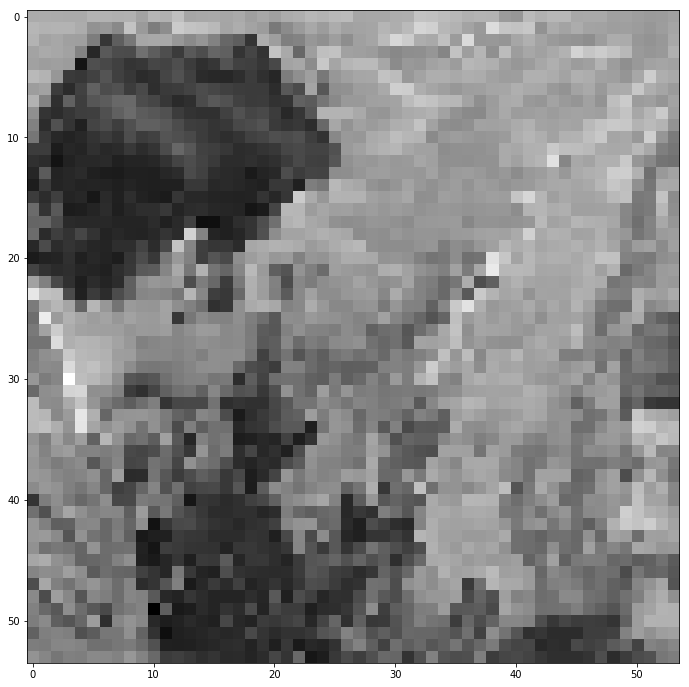

In [8]:
image = video_ar[:, :, 2000]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(np.rot90(image), cmap=plt.gray())

# AR(2) filtering

In [9]:
alpha, beta = -.61803, .61803-1. +.5

In [10]:
%%time
video_ar = video + alpha * np.roll(video, 1, axis=-1) + beta * np.roll(video, 2, axis=-1)

CPU times: user 447 ms, sys: 272 ms, total: 719 ms
Wall time: 723 ms


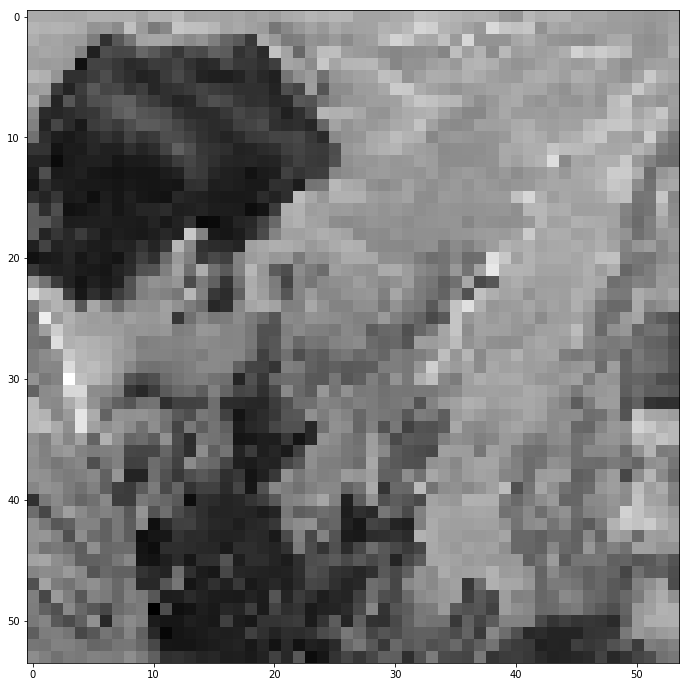

In [11]:
image = video_ar[:, :, 2000]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(np.rot90(image), cmap=plt.gray())

# ARMA(2, 1) filtering

In [12]:
alpha, beta, gamma = -.61803, .61803-1., .5

In [13]:
%%time
video_ar = video + alpha * np.roll(video, 1, axis=-1) + beta * np.roll(video, 2, axis=-1)
for t in range(5):
    video_ar += gamma**t * np.roll(video_ar, t+1, axis=-1)

CPU times: user 1.76 s, sys: 823 ms, total: 2.58 s
Wall time: 2.58 s


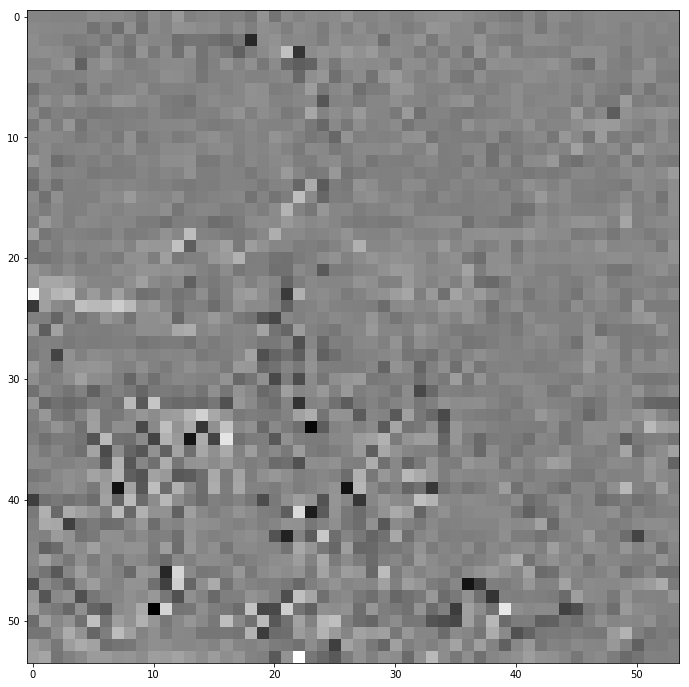

In [14]:
image = video_ar[:, :, 2000]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(np.rot90(image), cmap=plt.gray())

In [15]:
image = video_ar[:, :, 2000]

video = video_ar 

# designing filters

lg.pe.B_sf 0.4


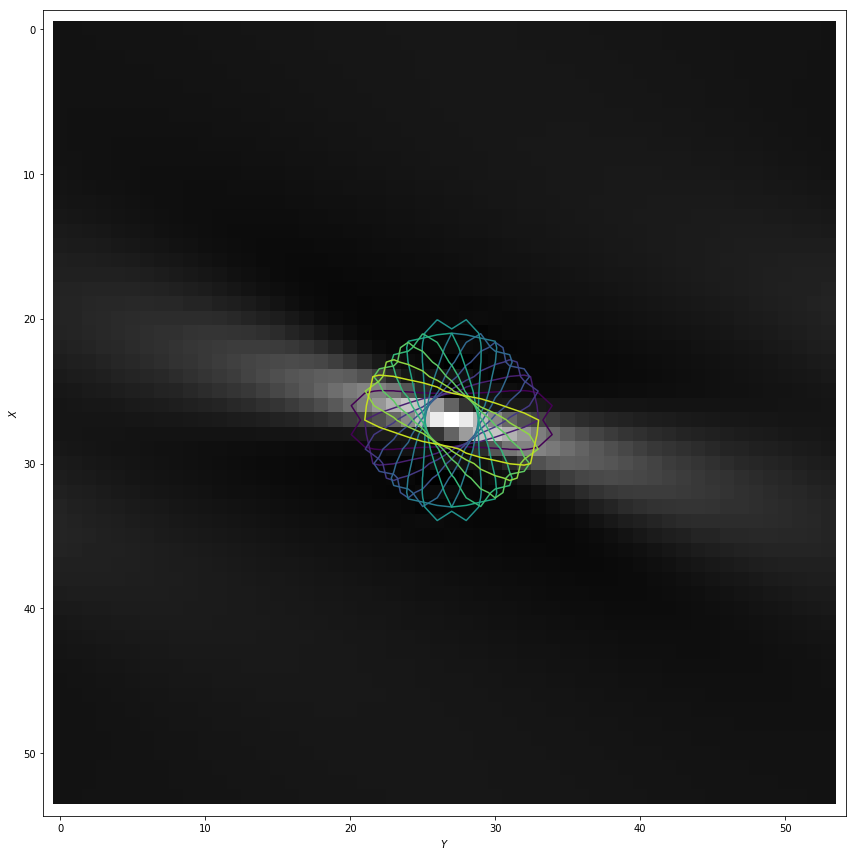

In [16]:

#from SLIP import Image, imread
from LogGabor import LogGabor
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.05, 'B_sf': 1.5, 'B_theta': lg.pe.B_theta}
print('lg.pe.B_sf', lg.pe.B_sf)

N_theta, N_phase = 12, 2
theta = np.linspace(0, np.pi, N_theta)

phi = np.zeros((N_theta, N_phase, N_X, N_Y))

for i_theta in range(N_theta):
    x = N_X/2
    y = N_Y/2
    params.update(theta=i_theta*np.pi/N_theta)
    for i_phase in range(N_phase):
        #print('At', i_theta, i_orient, i_scale, i_phase, 'x, y=', x, y, 'params=', params)
        phase = i_phase * np.pi/2
        kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
        phi[i_theta, i_phase, :] = lg.normalize(kernel)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))

ax.imshow(phi[i_theta, 0, :], cmap=plt.gray())

for i_theta in range(N_theta):
    env = np.sqrt(phi[i_theta, 0, :]**2 + phi[i_theta, 1, :]**2)
    ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
#fig.suptitle('Tiling of visual space using phi')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
#plt.savefig('logPolar_shape.pdf')

In [17]:
lg.pe.B_theta*180/np.pi

9.99999155336135

In [18]:
lg.mask.max()

0.9994144058011857

# filtering images

In [19]:
image_ = (image*lg.mask).reshape((N_X*N_Y))
print('image_.shape', image_.shape)

image_.shape (2916,)


In [20]:
phi_ = phi.reshape((N_theta, N_phase, N_X*N_Y))
print('phi_.shape', phi_.shape)

phi_.shape (12, 2, 2916)


In [21]:
code = phi_ @ image_
print('All scalar products in one shot = ', (code).shape )

All scalar products in one shot =  (12, 2)


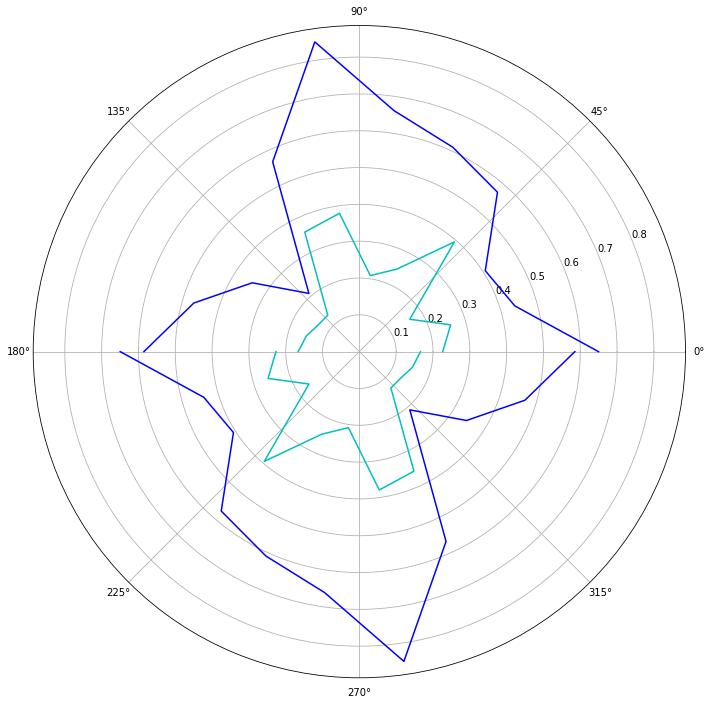

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH, FIG_WIDTH), subplot_kw=dict(projection='polar'))
for i, c in enumerate(['c', 'b']): 
    ax.plot(theta, np.abs(code[:, i])**.5, color=c)
    ax.plot(theta+np.pi, np.abs(code[:, i])**.5, color=c)


In [23]:
%%timeit
code = phi_ @ image_

101 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# filtering video

In [24]:
video_ = video.reshape((N_X*N_Y, N_frame))
print('video_.shape', video_.shape)

video_.shape (2916, 4096)


In [25]:
phi_ = phi.reshape((N_theta, N_phase, N_X*N_Y))
print('phi_.shape', phi_.shape)

phi_.shape (12, 2, 2916)


In [26]:
code = phi_ @ video_
print('All scalar products in one shot = ', (code).shape )

All scalar products in one shot =  (12, 2, 4096)


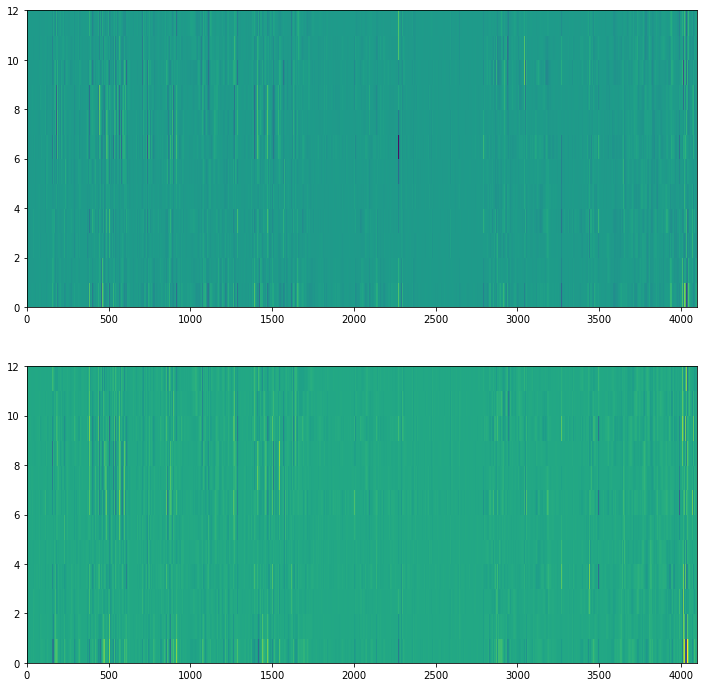

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_WIDTH))

for i in range(2): axs[i].pcolormesh(code[:, i, :], cmap=plt.viridis())


In [28]:
%%timeit
code = phi_ @ video_

664 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# temporal evolution

In [29]:
code2 = np.sum(code**2, axis=1)
print('code2.shape', code2.shape)

code2.shape (12, 4096)


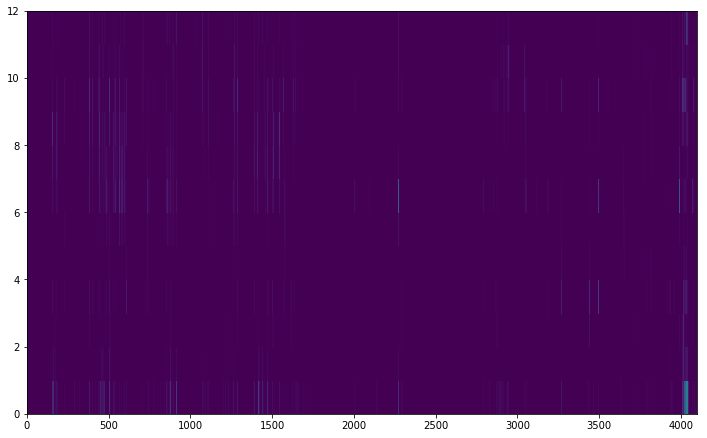

In [30]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax.pcolormesh(code2, cmap=plt.viridis())


# temporal evolution

In [31]:
theta_mean = np.sum(code2, axis=1)
print('theta_mean.shape', theta_mean.shape)

theta_mean.shape (12,)


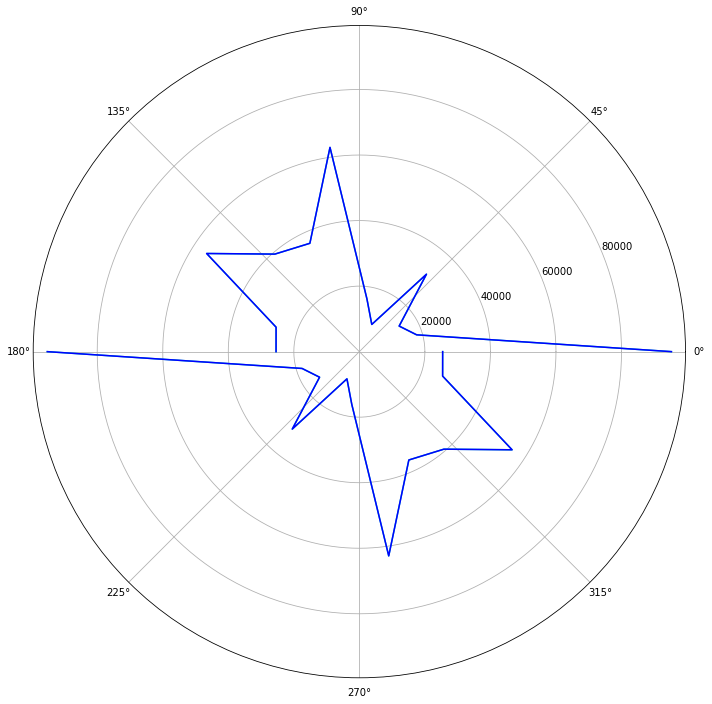

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH, FIG_WIDTH), subplot_kw=dict(projection='polar'))
for i, c in enumerate(['c', 'b']): 
    ax.plot(theta, theta_mean, color=c)
    ax.plot(theta+np.pi, theta_mean, color=c)


In [33]:
code2_mean = np.mean(code2, axis=0)
print('code2_mean.shape', code2_mean.shape)

code2_mean.shape (4096,)


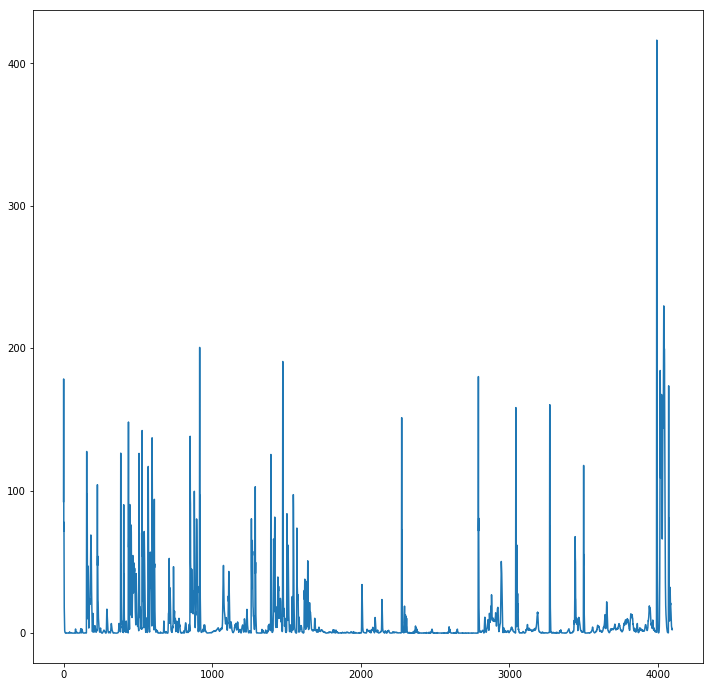

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH, FIG_WIDTH))

ax.plot(code2_mean)


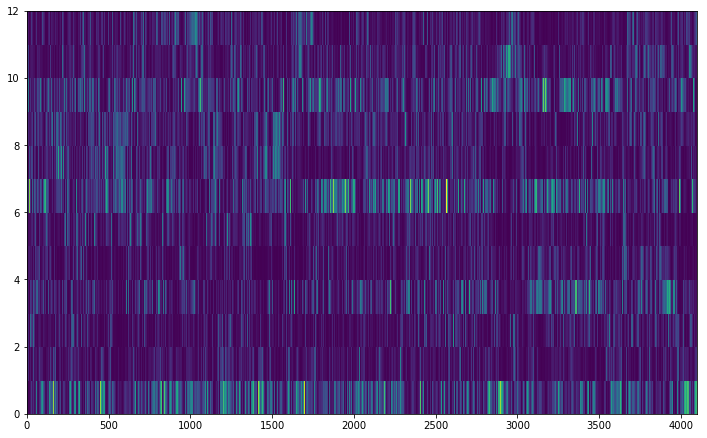

In [35]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax.pcolormesh(code2/code2_mean[None, :], cmap=plt.viridis())


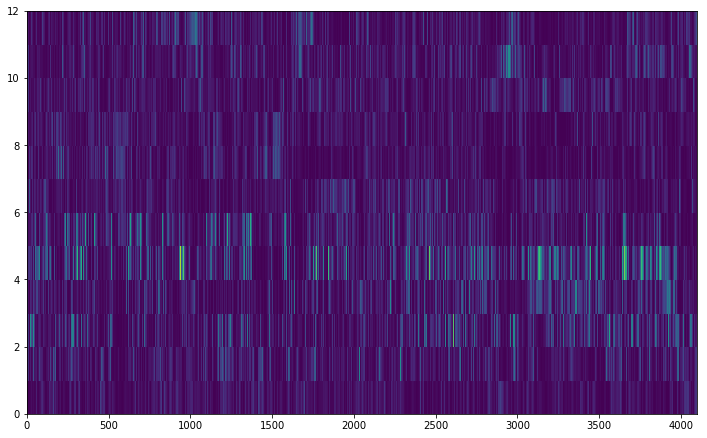

In [36]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax.pcolormesh(code2/code2_mean[None, :]/theta_mean[:, None], cmap=plt.viridis())
